In [1]:
# Solving the committor equation via neural network representation
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import torch

# A variational neural network-based solver for the committor problem
Ref.: Qianxiao Li, Bo Lin,  Weiqing Ren, "*Computing committor functions for the study of rare events using deep learning*", J. Chem. Phys. 151, 054112 (2019)
https://pubs.aip.org/aip/jcp/article-abstract/151/5/054112/198621/Computing-committor-functions-for-the-study-of

The committor problem for the overdamped Langevin dynamics
$$ dX_t = - \nabla V(X_t)dt + \sqrt{2\beta^{-1}}dW_t,\quad X_t\in\mathbb{R}^d,$$
is the following. Let $A$ and $B$ be disjoint regions surrounding metastable states, e.g. neighborhoods of two local minima of $V(x)$. The committor function $q(x)$ is the probability that the process starting at $x$ will hit first set $B$ rather than set $A$. The committor is the solution to the following boundary value problem for the backward Kolmogorov equation: 
$$\nabla\cdot\left(e^{-\beta V(x)}\nabla q(x)\right) = 0,\quad x\in\Omega_{AB}:=\mathbb{R}^d\backslash (A\cup B),$$
$$ q(\partial A) = 0,\quad q(\partial B) = 0.$$

The comiitor problem is linear, self-adjoint, and the function $e^{\-beta V(x)}$ is positive.
Therefore, the committor problem has the following variational formulation:
$q(x)$ is the minimizer of the Dirichlet form 
$$I[u]: = \int_{\Omega_{AB}} e^{-\beta V(x)}\|\nabla u(x)\|^2dx$$
among all $u\in C^2(\Omega_{AB})\cap C(\bar{\Omega}_{AB})$ satisfying the boundary conditions $u(\partial A) = 0$, $u(\partial B) = 1$.

This fact inspires the following optimization problem for the committor. We propose a solution model
$$ q(x) = F(x,\theta): = (1-\chi_{A}(x))*((1-\chi_B(x))*N(x;\theta) + \chi_B(x))$$
where $\chi_A(x)$ and $\chi_B(x)$ are smoothed indicator functions of $\partial A$ and $\partial B$, respectively, and $N(x;\theta)$ is a neural network function, where $\theta$ is the vector of all parameters of the neural network. Note that $F(x,\theta)$ is designed to satisfy the boundary conditions. Then we optimize $I[F(x;\theta)]$ with respect to $\theta$. Then the resulting $F(x;\theta)$ is the solution to the committor problem.

In this code, we apply this method to a 2D committor problem where $V(x)$ is the face potential, and the sets $A$ and $B$ are neighborhoods of the minima located in the "eyes". 

Since this is a 2D problem, we compare its solution to the finite element solution. We use the weigted absolute error as the error metric, where weights are the probability density of reactive trajectories. This error metric was used in

Ref.: Jiaxin Yuan, Amar Shah, Channing Bentz, Maria Cameron, "*Optimal control for sampling the transition path process and estimating rates*", Communications in Nonlinear Science and Numerical Simulation, Volume 129, February 2024, 107701, 

https://arxiv.org/abs/2305.17112,

https://www.sciencedirect.com/science/article/pii/S1007570423006226?casa_token=2DfEtNNRr_IAAAAA:AzGAlv091e36p9nCumWP7NPWAQv15JhoTMUJ4JkF-m3phE1N1_9WIXz58ajxdKO3iCCePGlT7t4


In [3]:
beta = torch.tensor(0.5) # inverse temperature

# The numpy-type potential function
def Vpot(xy):
    xa=-3
    ya=3
    xb=0 
    yb=4.5
    x = xy[:,0]
    y = xy[:,1]
    f=(1-x)**2+(y-0.25*x**2)**2+1
    g1=1-np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2=1-np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3=1.2-np.exp(-2*((x+0)**2+(y-2)**2))
    g4=1+np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))
    v = f*g1*g2*g3*g4
    return v


In [4]:
# The torch tensor-type potential function
def Vpot_torch(x,y):
    xa=torch.tensor([-3])
    ya=torch.tensor([3])
    xb=torch.tensor([0]) 
    yb=torch.tensor([4.5])

    f=(1-x).pow(2)+(y-0.25*x.pow(2)).pow(2)+1
    g1=1-torch.exp(-0.125*((x-xa).pow(2)+(y-ya).pow(2)))
    g2=1-torch.exp(-0.25*(((x-xb).pow(2)+(y-yb).pow(2))))
    g3=1.2-torch.exp(-2*((x+0).pow(2)+(y-2).pow(2)))
    g4=1+torch.exp(-2*(x+1.5).pow(2)-(y-3.5).pow(2)-(x+1)*(y-3.5))

    v = f*g1*g2*g3*g4
    return v  

In [5]:
# define grid points
nx,ny= (100,100)
nxy = nx*ny
xmin = -4.5
xmax = 4
ymin = -3
ymax = 6
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))

v = np.zeros(nxy)
xy = np.concatenate((x_vec,y_vec),axis=1)
v = Vpot(xy)
v_grid = np.reshape(v,(nx,ny))    


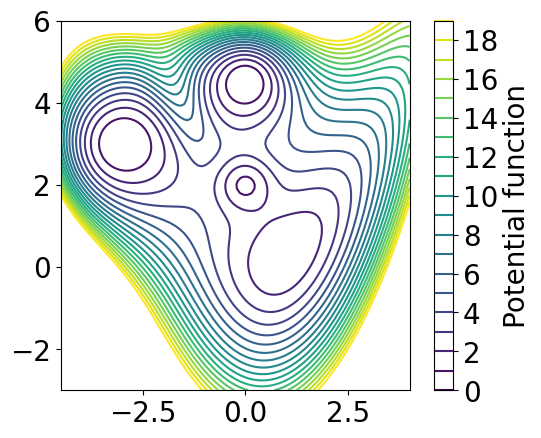

In [6]:
# plot face potential
plt.rcParams.update({'font.size': 20})
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)


In [7]:
# The neural network function: N(x) = Sigmoid(W3@tanh(W2@tanh(W1@tanh(W0@xy+b0)+b1)+b2)+b3)
# The solution model: F(x) = (1-chia(x))*((1-chib(x))*N(x) + chib(x))

class CommittorModelNN(torch.nn.Module):

    def __init__(self,in_size, hidden_size, out_size):
        super(CommittorModelNN, self).__init__()

        self.linear0 = torch.nn.Linear(in_size, hidden_size)
        self.activation0 = torch.nn.Tanh()
        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation2 = torch.nn.Tanh()
        self.linear3 = torch.nn.Linear(hidden_size, out_size)
        self.sigmoid = torch.nn.Sigmoid()
                              
    def forward(self,x,a,b,ra,rb,ea,eb,fac):
        q = self.linear0(x)
        q = self.activation0(q)
        q = self.linear1(q)
        q = self.activation1(q)
        q = self.linear2(q)
        q = self.activation2(q)
        q = self.linear3(q)
        q = self.sigmoid(q) 
        sizex, nothing = x.shape
        aux0 = (((x-a).pow(2)).sum(dim=1)).reshape(sizex,1) - (ra+ea.clone().detach()).pow(2)
        aux1 = (((x-b).pow(2)).sum(dim=1)).reshape(sizex,1) - (rb+eb.clone().detach()).pow(2)
        chia = 0.5-0.5*torch.tanh(fac*aux0)
        chib = 0.5-0.5*torch.tanh(fac*aux1)   
        q = (1-chia)*((1-chib)*q+chib)
        return q

# define sets A and B
minimum_a = np.array([-3,3])
a = torch.from_numpy(minimum_a)
minimum_b = np.array([0,4.5])
b =  torch.from_numpy(minimum_b)

ra = torch.tensor(0.5)
rb = torch.tensor(0.5)
fac = torch.tensor(100.)
ea = 2./(ra*fac)
eb = 2./(rb*fac)
# define the dimensions for the neural network
in_size = 2 # the dimension of input data points
hidden_size = 25 # the number of neurons in the hidden layer
out_size = 1 # the output size of the neural network

# test neural network
qmodel = CommittorModelNN(in_size, hidden_size, out_size)
print(qmodel)

CommittorModelNN(
  (linear0): Linear(in_features=2, out_features=25, bias=True)
  (activation0): Tanh()
  (linear1): Linear(in_features=25, out_features=25, bias=True)
  (activation1): Tanh()
  (linear2): Linear(in_features=25, out_features=25, bias=True)
  (activation2): Tanh()
  (linear3): Linear(in_features=25, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
# import training points
ftraindata_name = "Face_DeltaNet.npz"
data = np.load(ftraindata_name);
xytrain = data['delta_net']
Ndata = np.size(xytrain,axis=0)
print(xytrain[0:10,:])

# Remove training points lying in the sets A and B
da2 = np.sum((xytrain - np.outer(np.ones((Ndata,)),minimum_a))**2,axis=1)
db2 = np.sum((xytrain - np.outer(np.ones((Ndata,)),minimum_b))**2,axis=1)
indA = np.argwhere(da2 < (ra.numpy())**2)
indB = np.argwhere(db2 < (rb.numpy())**2)
ind = np.arange(Ndata)
ind_keep = np.setdiff1d(ind, np.union1d(indA,indB))

xy_omegaAB = xytrain[ind_keep,:]
train_data = torch.from_numpy(xy_omegaAB).float()
train_data.requires_grad_(True)
print(train_data[0:10,:])

size1,size2 = train_data.shape
print(size1,size2)


xy = train_data[0:2,:]
print(xy)
print("net = ",qmodel(xy,a,b,ra,rb,ea,eb,fac))

[[-3.          3.        ]
 [-2.79207381  2.82768563]
 [-2.66896076  2.79594137]
 [-2.73213345  2.68044454]
 [-2.58848633  2.68847665]
 [-2.73909069  2.75955781]
 [-2.73512939  3.03589689]
 [-2.81253309  2.94962946]
 [-2.86034402  3.01683678]
 [-2.67426636  2.91826648]]
tensor([[-2.5885,  2.6885],
        [-2.5120,  3.1755],
        [-2.5689,  2.4749],
        [-2.4433,  2.3624],
        [-2.3070,  2.5675],
        [-2.4325,  2.4747],
        [-2.4663,  2.4361],
        [-2.4660,  2.6880],
        [-2.4446,  2.7971],
        [-2.6265,  2.5975]], grad_fn=<SliceBackward0>)
7617 2
tensor([[-2.5885,  2.6885],
        [-2.5120,  3.1755]], grad_fn=<SliceBackward0>)
net =  tensor([[0.0024],
        [0.0040]], dtype=torch.float64, grad_fn=<MulBackward0>)


In [9]:
# To train the data in batch we need to use 'TensorDataset' and 'DataLoader'
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

rhs = torch.zeros(size1,)

train_dataset = TensorDataset(train_data,rhs)

batch_size = 256 # the batch size is the size of the training data/125

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

loss_fn = torch.nn.L1Loss()

# Here we define the optimizer with learning rate 5e-2:
optimizer1 = optim.Adam(qmodel.parameters(), lr=1e-3)

# reduce the learning rate at the listed epochs by the factor of gamma
scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[1000,2000,3000], gamma=0.1)


In [10]:
Nepochs = 300
# N1 = 100
# beta0 = beta
# beta = torch.tensor(0.5)

In [11]:
# training qmodel

loss = 1
for epoch in range(Nepochs):
    for X,y in train_dataloader:
        optimizer1.zero_grad()

        q = qmodel(X,a,b,ra,rb,ea,eb,fac)
        # print(q)
        
         # potential function with bumps
        V = Vpot_torch(X[:,0],X[:,1])
        
        # #Here we use autograd to calculate the derivative of Q with respect to input X:
        derivQ = torch.autograd.grad(q,X,grad_outputs = torch.ones_like(q),allow_unused=True,\
                                     retain_graph=True,create_graph=True)
        dq = derivQ[0]
        # print("derivQ = ",derivQ)
        # print("derivQ[0] = ",dq)
        # Here to calculate the values of '|\nabla q|^2 e^{\beta*U_bias}'
        # aux = torch.norm(derivQ[0],dim=1)**2
        # aux2 = torch.exp(beta*U_bias)
        # print(aux)
        # print(aux2)
        integrand = (torch.norm(derivQ[0],dim=1)**2)*torch.exp(-beta*V)
        # print((torch.norm(derivQ[0],dim=1)**2).detach().shape)
        # print(torch.exp(beta*U_bias).shape)
        # loss_fn is L1 loss, this is equivalent to taking the absolute value of the 
        # 'output' variable
        loss = torch.sum(integrand) #loss_fn(integrand, y)
        # These two lines are for updating parameters of neural network
        loss.backward()
        optimizer1.step()
        
    scheduler1.step()
    if epoch%10 == 0:
        print(epoch)
        print('epoch = ',epoch,'loss: ',loss)


0
epoch =  0 loss:  tensor(80.2310, grad_fn=<SumBackward0>)
10
epoch =  10 loss:  tensor(5.2852, grad_fn=<SumBackward0>)
20
epoch =  20 loss:  tensor(2.3851, grad_fn=<SumBackward0>)
30
epoch =  30 loss:  tensor(2.4860, grad_fn=<SumBackward0>)
40
epoch =  40 loss:  tensor(1.4563, grad_fn=<SumBackward0>)
50
epoch =  50 loss:  tensor(1.2015, grad_fn=<SumBackward0>)
60
epoch =  60 loss:  tensor(1.3593, grad_fn=<SumBackward0>)
70
epoch =  70 loss:  tensor(1.8724, grad_fn=<SumBackward0>)
80
epoch =  80 loss:  tensor(1.4731, grad_fn=<SumBackward0>)
90
epoch =  90 loss:  tensor(1.8205, grad_fn=<SumBackward0>)
100
epoch =  100 loss:  tensor(1.4092, grad_fn=<SumBackward0>)
110
epoch =  110 loss:  tensor(1.5038, grad_fn=<SumBackward0>)
120
epoch =  120 loss:  tensor(1.4809, grad_fn=<SumBackward0>)
130
epoch =  130 loss:  tensor(1.1919, grad_fn=<SumBackward0>)
140
epoch =  140 loss:  tensor(1.1926, grad_fn=<SumBackward0>)
150
epoch =  150 loss:  tensor(1.4802, grad_fn=<SumBackward0>)
160
epoch =  

FaceCommittorBeta0.5.pdf


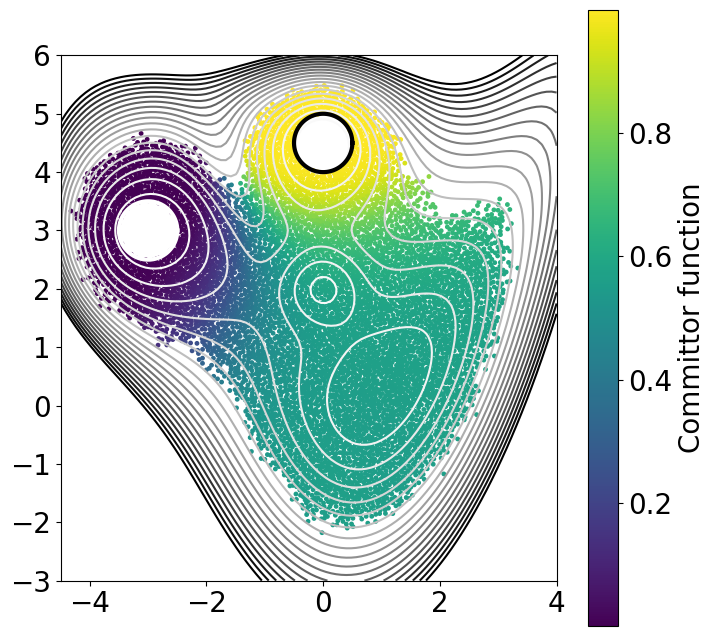

In [12]:
# visualize the computed committor

q_train_data = qmodel(train_data,a,b,ra,rb,ea,eb,fac)

t=np.linspace(0,2*np.pi,100)
Abdry_x = a[0] + ra*np.cos(t)
Abdry_y = a[1] + ra*np.sin(t)
Bbdry_x = b[0] + rb*np.cos(t)
Bbdry_y = b[1] + rb*np.sin(t)

plt.figure(figsize=(8, 8))
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20),cmap = "Greys")
plt.scatter(xy_omegaAB[:,0],xy_omegaAB[:,1],s = 6, c = q_train_data.detach(),cmap = "viridis")
plt.plot(Abdry_x,Abdry_y,linewidth=3,color='white')
plt.plot(Bbdry_x,Bbdry_y,linewidth=3,color='black')
plt.colorbar(label="Committor function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
figname = "FaceCommittorBeta" + str(beta.numpy())+".pdf"
print(figname)
plt.savefig(figname)



In [13]:
# Check against the FEM solution
# fname = "FEM_face_output"+str(beta)
# np.savez(fname,pts = pts,tri = tri, q = q)
fname = "FEM_face_output"+str(beta.numpy())+".npz"
FEMdata = np.load(fname)
FEMpts = FEMdata['pts']
FEMtri = FEMdata['tri']
FEMq = FEMdata['q']

In [14]:
NNq = qmodel(torch.from_numpy(FEMpts).float(),a,b,ra,rb,ea,eb,fac).detach().numpy().flatten()
print(np.shape(FEMpts))
print(np.shape(FEMtri))
print(np.shape(NNq))

(4153, 2)
(8004, 3)
(4153,)


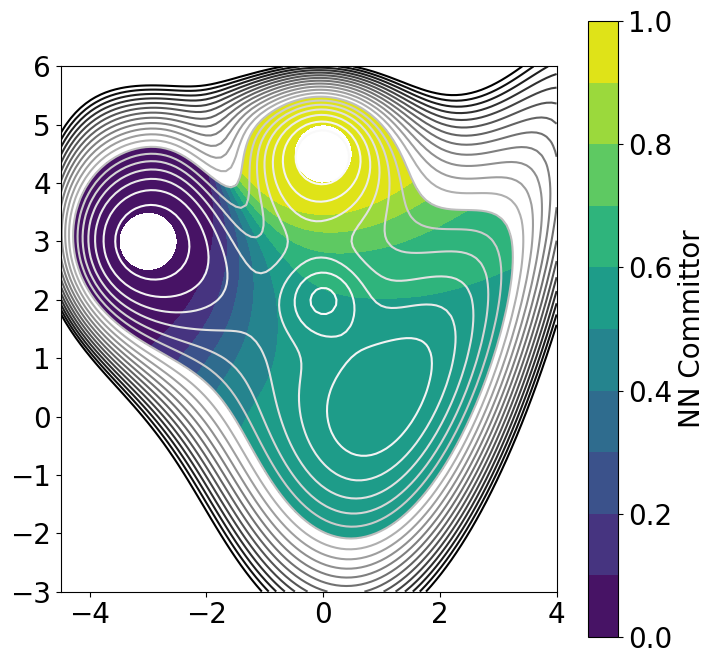

In [15]:
plt.figure(figsize=(8, 8))
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20),cmap = "Greys")
plt.tricontourf(FEMpts[:,0], FEMpts[:,1],FEMtri,NNq,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
plt.colorbar(label="NN Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)

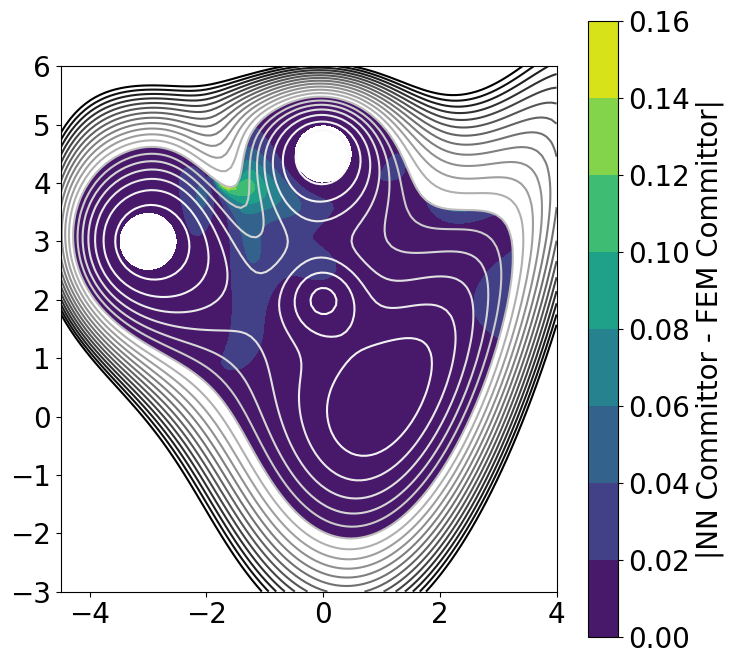

In [16]:
# plot error
plt.figure(figsize=(8, 8))
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20),cmap = "Greys")
plt.tricontourf(FEMpts[:,0], FEMpts[:,1],FEMtri,np.abs(NNq-FEMq))
plt.colorbar(label="|NN Committor - FEM Committor|", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)

In [17]:
# Compute the weighted absolute error (WAE)
w = FEMq*(1-FEMq)*np.exp(-beta.numpy()*Vpot(FEMpts))
wsum = np.sum(w)
WAE = np.sum(w*np.abs(NNq-FEMq))/wsum
print(f"WAE = {WAE:.3e}")
                         

WAE = 9.048e-03


In [42]:
# Compute the mean absolute error (MAE)
MAE = np.sum(np.abs(NNq-FEMq))/np.size(NNq)
print(f"MAE = {MAE:.3e}")


MAE = 1.155e-02


In [ ]:
# Compute the root mean square error (RMSE)
RMSE = np.sqrt(np.sum(np.abs(NNq-FEMq)**2)/np.size(NNq))
print(f"RMSE = {MAE:.3e}")
